# Работа с геоданными

In [1]:
import numpy as np
import pandas as pd 
from scipy.stats import binned_statistic_2d as bin_s

In [2]:
data_Taxi_May_2016=pd.read_csv('/Users/sergeyanufriev/Desktop/Yellow Taxi Data/NYC Taxi 2016/yellow_tripdata_2016-05.csv')

In [3]:
data_regions = pd.read_csv('regions.csv',sep=';')

In [4]:
North_South = data_regions[['north','south']]
North_South = North_South.as_matrix()

West_East = data_regions[['west','east']]
West_East = West_East.as_matrix()

longitude = np.unique(West_East)
latitude  = np.unique(North_South)

binx = longitude
biny = latitude

In [5]:
def Data_Aggregate(x):
    
    df = x
    
    # нулевой длительностью
    df = df.drop(df.index[df['tpep_pickup_datetime']==df['tpep_dropoff_datetime']])
    # нулевым количеством пассажиров
    df = df.drop(df.index[df['passenger_count']==0])
    df = df.drop(df.index[df['trip_distance']==0])
    # координатами начала, не попадающими в прямоугольник Нью-Йорка
    df = df[(df.pickup_longitude > -74.25559) & (df.pickup_longitude<-73.70001) & (df.pickup_latitude > 40.49612 ) & (df.pickup_latitude <40.91553)]
    
    latitude_data  = np.asarray(df.pickup_longitude)
    longitude_data = np.asarray(df.pickup_latitude)
    
    ret = bin_s(latitude_data, longitude_data, None, 'count', bins=[binx,biny],\
                expand_binnumbers=True)

    array = ret.binnumber
    
    # Функция номера метки от binX, binY. Найденна в таблице сетки районов
    def myfun(i,j):
        z=(i-1)*50 +j
        return z
    
    # Находим вектор меток района для каждой паре координат
    array = np.transpose(array)

    vfunc = np.vectorize(myfun)

    x=array[:,0]  # BinX
    y=array[:,1]  # BinY

    id_location = vfunc(x, y)
    
    df['ID Area'] = id_location
    
    matrix =  df[['tpep_pickup_datetime','passenger_count','ID Area']].as_matrix()
    
    # Находим районы которых нет в таблице выше 
    x = np.arange(2501)
    y = np.unique(df['ID Area'])

    mask = np.in1d(x, y,invert=True)
    z = np.unique(x[mask])
    z = z[1:]
    z = z.astype(int)
    
    x1 = np.repeat('2016-05-01 00:00:07',z.shape[0])
    x2 = np.repeat(0,z.shape[0])
    x3 = z
    
    x1 = np.array(x1, dtype=object)
    x2 = np.array(x2, dtype=object)
    z =  np.array(z,  dtype=object)
    
    k = np.vstack((x1,x2))
    matrix_zero = np.vstack((k,z))
    matrix_zero = np.transpose(matrix_zero)
    
    
    new_matrix = np.vstack((matrix,matrix_zero))
    
    
    df_new = pd.DataFrame(data=new_matrix,columns=['tpep_pickup_datetime',\
                                  'passenger_count','ID Area'])
    
    df_new2 = df_new.set_index(pd.DatetimeIndex(df_new['tpep_pickup_datetime']))
    
    df_new2=df_new2[['passenger_count','ID Area']]
    
    
    # Групировка по часам и районам
    grouper = df_new2.groupby([pd.TimeGrouper('1H'), 'ID Area'])
    result = grouper['passenger_count'].sum().unstack('ID Area').fillna(0)
    
    
    return result 

In [6]:
import timeit

### 1) Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.

In [7]:
start = timeit.default_timer()

Agg_Data_May_2016 = Data_Aggregate(data_Taxi_May_2016)

stop = timeit.default_timer()

print stop - start 

60.7113189697


In [8]:
matrix =Agg_Data_May_2016.as_matrix()
trips_sum = np.sum(matrix, axis=0)

In [9]:
print 'кол-во ячеек из которых в мае не было совершено ни одной поездки' , 2500-np.nonzero(trips_sum)[0].shape[0]

кол-во ячеек из которых в мае не было совершено ни одной поездки 1283


### 2) Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
%matplotlib inline

/Users/sergeyanufriev/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


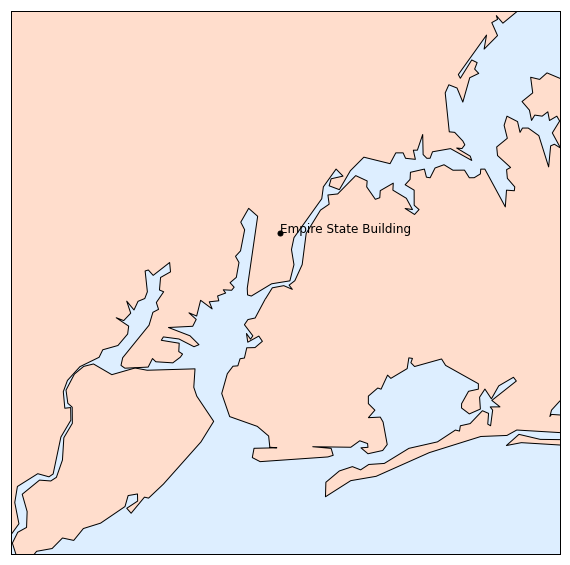

In [11]:
west, south, east, north = -74.26, 40.50, -73.70, 40.92
 
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
 
m = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
            llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='h')


m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()

x, y = m(-73.985664, 40.748441)
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, 'Empire State Building', fontsize=12);



plt.show()

### 3) Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.

In [12]:
# Изменим размерность вектора данных суммарных поездок из 1D(len=2500) в 2D,
# где вертекальные и горизонтальные оси матрицы являются широтой и долготой соответсвенно
trips_reshaped = np.flipud(np.transpose(trips_sum.reshape((50,50))))

/Users/sergeyanufriev/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/sergeyanufriev/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


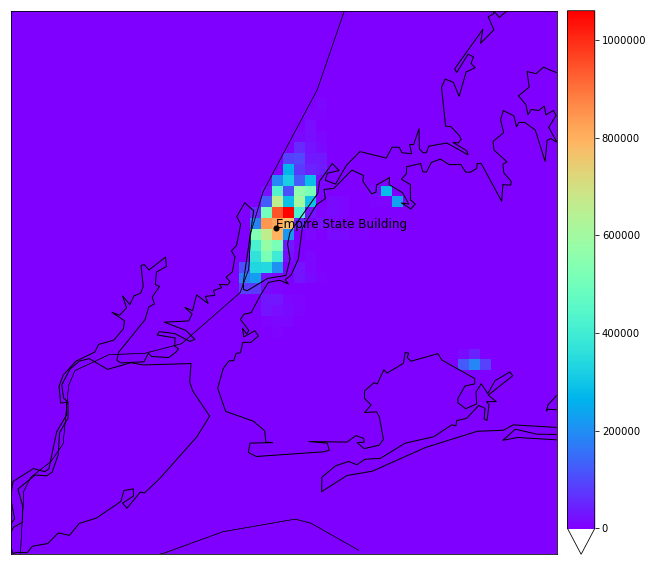

In [13]:
west, south, east, north = -74.25559, 40.49612, -73.70001, 40.91553
 
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
 
m = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
            llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='h')

m.drawcoastlines()
m.drawstates()

lon = longitude
lat = latitude

data = trips_reshaped

x,y = m(lon,lat)

my_cmap = plt.get_cmap('rainbow')
my_cmap.set_under('white')
cs = m.pcolormesh(x,y,np.flipud(data),cmap = my_cmap)
m.colorbar(cs, extend = 'min')


x1, y1 = m(-73.985664, 40.748441)
plt.plot(x1, y1, 'ok', markersize=5)
plt.text(x1, y1, 'Empire State Building', fontsize=12);


plt.show()

In [14]:
# Карта действительно имеет смысл. Красное пятно над Empire state это район вокзала Grand Central. 
# Сгустки цвета от манхетана это 2 аэропорта. 

### 4)Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.

Находим координаты статуи свободы: https://www.gps-latitude-longitude.com/gps-coordinates-of-statue-of-liberty  
Longitude: -74.044500
Latitude:   40.689249

In [15]:
import folium
map_osm = folium.Map(location=[40.748441,-73.985664],zoom_start=10)
folium.Marker([40.748441, -73.985664], popup='Empire state building').add_to(map_osm)
folium.Marker([40.689249, -74.044500 ], popup='Statue of Liberty').add_to(map_osm)
map_osm

# Нажмите на синие маркеры,высвятятся имена статуи свободы и эмпайер стэит билдинг

### 5) Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

In [16]:
trips_average = np.mean(matrix,axis=0)

In [17]:
regions = data_regions

In [18]:
features = []
for row in regions.iterrows():
    r = row[1]
    feature = {
        "type": "Feature",
        "region": int(r.region),
        "geometry": {
            "type": "Polygon",
            "coordinates":[[
                [r.west, r.north],
                [r.east, r.north],
                [r.east, r.south],
                [r.west, r.south],
                [r.west, r.north],
            ]]
        }
    }
    features.append(feature)
regions_json = {"type":"FeatureCollection","features": features }

In [19]:
trips = pd.DataFrame(trips_average)
trips['region'] = np.arange(1,2501)
trips.columns = ['average_trips', 'region']

In [20]:
sum_trips = trips

In [21]:
m = folium.Map(location=[40.748441,-73.985664],zoom_start=10)


m.choropleth(
    geo_data=regions_json,
    name='choropleth',
    data=sum_trips,
    columns=['region', 'average_trips'],
    key_on='feature.region',
    fill_color='YlOrBr',
    fill_opacity=0.7,
    line_opacity=0.05,
    legend_name='Average Trips'
)
folium.LayerControl().add_to(m)
m

### 6) Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. 

##### 6.1Посчитайте количество оставшихся. 

In [22]:
average_rate = np.mean(matrix,axis=0)

In [23]:
print 'количество оставшихся',np.where(average_rate >=5)[0].shape[0]

количество оставшихся 115


##### 6.2 Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны

In [24]:
# Регионы где поездок больше либо равно 5
new_index = np.where(average_rate >=5)[0]

In [25]:
regions_updated = regions[regions['region'].isin(new_index)]

In [26]:
sum_trips_updated = sum_trips[sum_trips['region'].isin(new_index)]

In [27]:
features = []
for row in regions_updated.iterrows():
    r = row[1]
    feature = {
        "type": "Feature",
        "region": int(r.region),
        "geometry": {
            "type": "Polygon",
            "coordinates":[[
                [r.west, r.north],
                [r.east, r.north],
                [r.east, r.south],
                [r.west, r.south],
                [r.west, r.north],
            ]]
        }
    }
    features.append(feature)
regions_json_updated = {"type":"FeatureCollection","features": features }

In [28]:
m = folium.Map(location=[40.748441,-73.985664],zoom_start=10)


m.choropleth(
    geo_data=regions_json_updated,
    name='choropleth',
    data=sum_trips_updated,
    columns=['region', 'average_trips'],
    key_on='feature.region',
    fill_color='YlOrBr',
    fill_opacity=0.7,
    line_opacity=0.05,
    legend_name='Average Trips'
)
folium.LayerControl().add_to(m)
m